<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/RBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cartopy

# **The Thin Plate RBF**
- **Function**: **`thin_plate`**

The specific mathematical form of the **Thin Plate Spline (TPS)** function used in the code is:


$K(r) = r^2 \log(r)$


Where:
- \( r \) is the Euclidean distance between two points, and
- \( K(r) \) is the **Radial Basis Function** that penalizes large distances by applying a logarithmic scaling.



In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import Rbf
import time

# === Load Data ===
print("Loading data...")

# Load the station data from CSV
data = pd.read_csv('basePM25nearest_grid.csv')  # Path to the station CSV file

# Load the model data from NetCDF
model_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')  # Path to the NetCDF file

# Extract necessary data from model (lat, lon, PM2.5 values)
model_lons = model_data['lon'].values  # Longitude values from the model grid
model_lats = model_data['lat'].values  # Latitude values from the model grid
model_values = model_data['SURF_ug_PM25_rh50'].values[0].astype(np.float32)  # Modeled PM2.5 values for the first time step

# Extract station data (lon, lat, observed PM2.5 values)
stations_data = data[['lon', 'lat', 'SURF_ug_PM25_rh50']].copy()
stations_data['nearest_SURF_ug_PM25_rh50'] = data['nearest_SURF_ug_PM25_rh50']

# Compute Bias (Observed - Modeled)
stations_data['bias'] = stations_data['SURF_ug_PM25_rh50'] - stations_data['nearest_SURF_ug_PM25_rh50']

# === Initialize Bias Correction Field ===
corrected_pm25 = model_values.copy()  # Start with the modeled PM2.5 values as the initial estimate

# === Create Rbf Model (TPS Interpolation) ===
print("Fitting Thin Plate Spline model...")

# Set up the Radial Basis Function (Rbf) interpolation with Thin Plate Spline
rbf = Rbf(stations_data['lon'].values, stations_data['lat'].values, stations_data['bias'].values, function='thin_plate')

# === Apply Correction to the Entire Grid ===
print("Applying TPS correction to model grid...")

# Create a meshgrid for the model grid (lat, lon)
grid_lons, grid_lats = np.meshgrid(model_lons, model_lats)

# Flatten the meshgrid to 1D arrays for Rbf input
grid_coords = np.vstack((grid_lons.ravel(), grid_lats.ravel())).T

# Apply TPS interpolation to the flattened grid
corrected_pm25 = rbf(grid_coords[:, 0], grid_coords[:, 1])

# Reshape the result to match the original grid shape
corrected_pm25 = corrected_pm25.reshape(len(model_lats), len(model_lons))  # Reshape to (lat, lon) dimensions

# === Save Corrected Data to NetCDF ===
print("Saving corrected NetCDF file...")

# Copy the original model data and drop the old PM2.5 variable
corrected_data = model_data.copy()
corrected_data = corrected_data.drop_vars("SURF_ug_PM25_rh50")

# Add the corrected PM2.5 values to the dataset as a new variable
corrected_data["SURF_ug_PM25_rh50_corrected"] = (["lat", "lon"], corrected_pm25)
corrected_data.attrs["description"] = "Bias-corrected PM2.5 using Thin Plate Spline (TPS)"

# Save the corrected data to a new NetCDF file
output_file = "BaseCase_PERT_PM25_rh50_YEARLY_corrected_TPS.nc"
corrected_data.to_netcdf(output_file)

# === End Timer ===
end_time = time.time()
print(f"\nTPS bias correction completed!")
print(f"Corrected NetCDF saved as: {output_file}")
print(f"Total execution time: {end_time - start_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


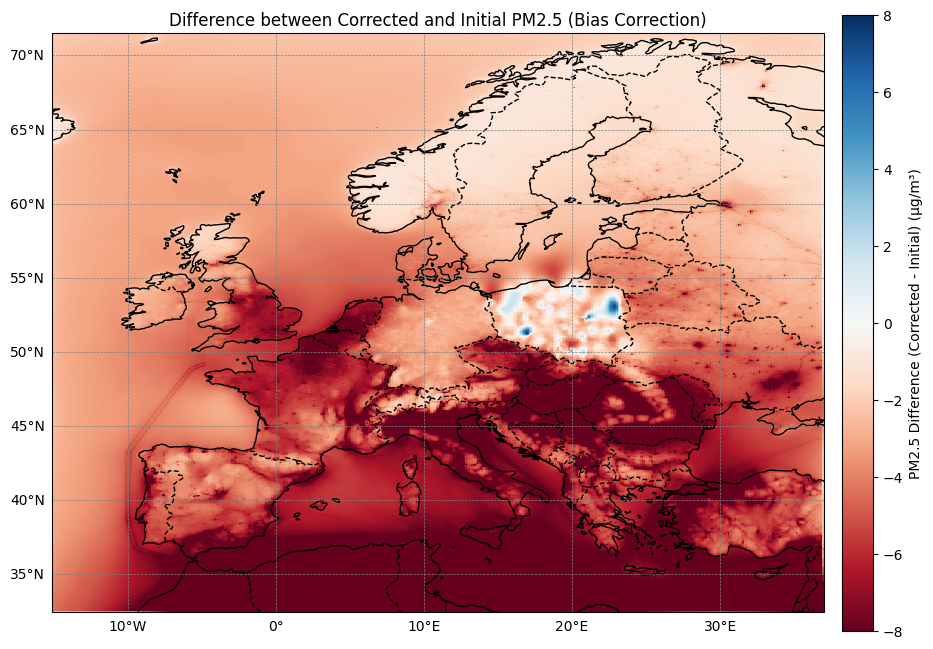

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Initial and Corrected NetCDF Files ===
initial_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
corrected_netcdf_path = "BaseCase_PERT_PM25_rh50_YEARLY_corrected_TPS.nc"  # Change this if needed

# Open NetCDF datasets
ds_initial = xr.open_dataset(initial_netcdf_path)
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract PM2.5 data (Ensure no time dimension)
initial_pm25 = ds_initial["SURF_ug_PM25_rh50"].squeeze().values
corrected_pm25 = ds_corrected["SURF_ug_PM25_rh50_corrected"].squeeze().values

# Compute difference (Corrected - Initial) and ensure correct shape
difference = (corrected_pm25 - initial_pm25).squeeze()

# Extract coordinates
lon = ds_initial["lon"].values
lat = ds_initial["lat"].values

# === Define Plot Limits ===
cbar_min = -8
cbar_max = 8

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the difference (Ensure shape consistency)
im = ax.pcolormesh(lon, lat, difference, transform=ccrs.PlateCarree(), cmap="RdBu", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("PM2.5 Difference (Corrected - Initial) (µg/m³)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.title("Difference between Corrected and Initial PM2.5 (Bias Correction)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close datasets
ds_initial.close()
ds_corrected.close()
